# Mineração de Dados: Classificação

**Grupo**:

- Gabriel Oliveira Moreira Faria
- Vinícius Oliveira

**Objetivo**:

O objetivo deste trabalho é criar classificadores que buscam prever a aprovação (ou reprovação) de discentes que participaram de um curso online.
Essas bases de dados apresentam características de pessoas que participaram do curso online "Prevenção do uso de drogas".


Os dados estão disponíveis na pasta do drive compartilhada aqui e são formados por 3 arquivos:
"trabalho5_dados_sociais_ID.csv" - dados sócio-econômicos e de perguntas iniciais respondidas pelos participantes,
"trabalho5_dados_modulo1_ID.csv" - dados de acesso ao sistema de ensino durante as atividades referentes ao primeiro módulo do curso, e
"trabalho5_dados_ateh_modulo2_ID.csv" - dados de acesso ao sistema de ensino para as atividades até o segundo módulo do curso.


Nesse trabalho geramos um modelo para cada um das 3 situações a seguir:
1) um modelo que considera apenas as características sócio-econômicos e de perguntas iniciais;
2) um modelo que considera apenas as características sócio-econômicos e de perguntas iniciais, e de acesso considerando o primeiro módulo do curso; e
3) um modelo que considera todos os dados disponíveis.

Para cada uma das 3 situações apresentadas, deve-se gerar ao menos 2 modelos de tipos distintos.

**Com a importância de analisar os parâmetros que fornecemos para os modelos**

## Trabalho 6 - Classificação, Avaliação Comparativa de Modelos e Extração de Conhecimento
---

- Uma restrição do trabalho atual é que ao menos um dos tipos de modelo utilizado deve possibilitar a extração de algum conhecimento da tomada de decisão.
- Por exemplo, quais características estão associadas a indivíduos reprovados?
- Por fim, é importante destacar que aqui as análises comparativas dos modelos devem ser mais completas e que o desbalanceamento dos dados deve ser tratado (apesar do desbalanceamento não ser muito grande).

In [4]:
import itertools as it
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import chisquare
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.tree import DecisionTreeClassifier

from math import sqrt

from sklearn import svm

In [21]:
class_names = ['Aprovado', 'Não Aprovado']

### Funções

---

In [5]:
def preprocess(df: pd.DataFrame, cols_ord=[], cats_ord=[], cols_nom=[], cols_num=[]):
    cols_ord_ = list(set(cols_ord) & set(df.columns))
    cats_ord_ = [cats_ord[cols_ord.index(col)] for col in cols_ord_]
    cols_nom_ = list((set(cols_nom)) & set(df.columns))
    cols_num_ = list(set(cols_num) & set(df.columns))

    transformers = []
    if cols_ord_:
        transform = (OrdinalEncoder(categories=cats_ord_), cols_ord_)
        transformers.append(transform)
    if cols_nom_:
        transform = (OneHotEncoder(), cols_nom_)
        transformers.append(transform)
    if cols_num_:
        transform = (StandardScaler(), cols_num_)
        transformers.append(transform)

    if transformers:
        steps = [("transformer", make_column_transformer(*transformers))]
        return Pipeline(steps).fit_transform(df)
    else:
        return df.to_numpy()


def search(X, y, path=None, read_cache=True, n_jobs=-1):
    try:
        if path is not None and read_cache:
            with open(path, "rb") as file:
                results = pickle.load(file)
        else:
            raise FileNotFoundError()
    except FileNotFoundError:
        pipe = Pipeline([("estimator", LogisticRegression())])
        search = GridSearchCV(
            pipe,
            param_grid=[
                {"estimator": [LogisticRegression()], "estimator__penalty": ["l1"]},
                {
                    "estimator": [DecisionTreeClassifier()],
                    "estimator__max_depth": [10, 20, None],
                },
                {
                    "estimator": [RandomForestClassifier()],
                    "estimator__n_estimators": [100, 250, 1000],
                },
            ],
            n_jobs=n_jobs,
            scoring="f1_micro",
        )
        _ = search.fit(X, y)
        results = pd.DataFrame(search.cv_results_).sort_values(
            by="mean_test_score", ascending=False
        )
        if path is not None:
            with open(path, "wb") as file:
                pickle.dump(results, file)

    return results


def cross_analysis(df, cols, margins=True, normalize=True):
    ctab = pd.crosstab([df[col] for col in cols], df["aprovado"], margins=margins)
    if normalize:
        ctab["Não"] = ctab["Não"] / ctab["All"]
        ctab["Sim"] = ctab["Sim"] / ctab["All"]
    return ctab

In [6]:
def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):


    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    plt.show()




In [7]:
def plot_roc_curve(X_test, y_test, y_predict, model, info):
    # Step 6: Predict probabilities for the test data.
    probs = model.predict_proba(X_test)#[:,1]
    # Step 7: Keep Probabilities of the positive class only.
    probs = probs[:, 1]
    # Step 8: Compute the AUC Score.
    auc = metrics.roc_auc_score(y_test, probs)
    print('\n----ROC Curve----\nAUC: %.2f' % auc)
    # Step 9: Get the ROC Curve.
    # false_positive_rate, true_positive_rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)
    print(metrics.auc(fpr, tpr),'\n-----------------\n')
    # Step 10: Plot ROC Curve using our defined function


    plt.plot(fpr, tpr, color='red', label='ROC') #orange
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - ' + info)
    plt.legend()
    plt.show()

In [8]:
def metrics_structure():
    results = pd.DataFrame({'Acuracy':[],
                            'Precision':[],
                            'Recall':[],
                            'F1-score':[],
                            'F-beta':[],
                            'TP':[],
                            'TN':[],
                            'ROC Curve':[]}, )
    results.index.names = ['Algoritmos']
    return results

In [10]:
def cross_validation_stratified(X, y, model, name, columns, balancer = None):

    results_cv = metrics_structure()

    tp = 0
    tn = 0
    fp = 0
    fn = 0
    auc_media = 0

    skfold = StratifiedKFold(n_splits=5)

    for fold, (train_index, test_index) in enumerate(skfold.split(X, y), 1):

        X_train = X[train_index]
        y_train = y[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
        X_test = X[test_index]
        y_test = y[test_index]  # See comment on ravel and  y_train
        if balancer is not None:
            X_train, y_train = balancer.fit_resample(X_train, y_train)
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)


        acuracy = metrics.accuracy_score(y_test, y_predict)
        precision = metrics.precision_score(y_test, y_predict)
        recall = metrics.recall_score(y_test, y_predict)
        f_score = metrics.f1_score(y_test, y_predict)
        f_beta = metrics.fbeta_score(y_test, y_predict, beta=2)
        ROC = metrics.roc_auc_score(y_test, y_predict)
        TP = len(y_test[(y_test==1) & (y_predict==1)])
        TN = len(y_test[(y_test==0) & (y_predict==0)])

        tp += len(y_test[(y_test==1) & (y_predict==1)])
        tn += len(y_test[(y_test==0) & (y_predict==0)])
        fp += len(y_test[(y_test==0) & (y_predict==1)])
        fn += len(y_test[(y_test==1) & (y_predict==0)])

        auc_media += ROC

        result_fold = [acuracy, precision, recall, f_score, f_beta, TP, TN, ROC]
        results_cv = results_cv.append(pd.DataFrame([result_fold], index=[('Fold' + str(fold))], columns=results_cv.columns))

        if fold == 1:
            print('best fold', str(fold))
            bestMetric = acuracy
            bestModel = model
            X_test_best = X_test
            y_test_best = y_test
            y_predict_best = y_predict

        elif acuracy > bestMetric:
            print('best fold', str(fold))
            bestMetric = acuracy
            bestModel = model
            X_test_best = X_test
            y_test_best = y_test
            y_predict_best = y_predict


    plot_confusion_matrix(y_test, y_predict, classes=class_names, title=name)
    plot_roc_curve(X_test_best, y_test_best, y_predict_best, model, name)

    acur = (tp+tn)/(tp+tn+fp+fn)
    prec = tp/(tp+fp)
    reca = tp/(tp+fn)
    f1sc = (2*reca*prec)/(reca+prec)
    f2sc = (5*reca*prec)/((4*prec)+reca)
    auc_media /= 10


    results_metrics = metrics_structure()
    results = [acur, prec, reca, f1sc, f2sc, tp, tn, auc_media]
    results_metrics = results_metrics.append(pd.DataFrame([results], index=[name], columns=results_metrics.columns))

    return results_metrics, results_cv, bestModel

### Carregamento dos dados

Primeiro, carregaremos os dados a partir dos arquivos fornecidos.

In [11]:
# Características
df_sociais = pd.read_csv("data/trabalho5_dados_sociais_4.csv")
df_modulo1 = pd.read_csv("data/trabalho5_dados_modulo1_4.csv")
df_modulo2 = pd.read_csv("data/trabalho5_dados_ateh_modulo2_4.csv")

### Análise exploratória

---

Agora, analisaremos o quanto cada característica da base de dados pode contribuir para a predição de aprovação ou não dos participantes do curso. Para isso, usaremos o teste do Qui-Quadrado para verificar a diferença entre a distribuição "geral" dos dados e dos subgrupos gerados pelas variáveis categóricas da base.

#### Relações entre características e aprovação

##### Dados socioeconômicos

In [454]:
results = {"column": [], "score": []}
for col in df_sociais.columns:
    if col in ["aprovado", "idade", "tempodeservico", "id"]:
        continue
    ctab = cross_analysis(df_sociais, [col], margins=True, normalize=False)
    for cat in ctab.index[:-1]:
        obs = ctab.loc[cat, ctab.columns[:-1]]
        exp = ctab.loc["All", ctab.columns[:-1]]
        exp = exp * obs.sum() / exp.sum()
        if obs.sum() > 13:
            score = chisquare(obs, exp).pvalue
        else:
            score = 1
        results["column"].append(col)
        results["score"].append(score)
cols_scores_se = (
    pd.DataFrame(results).groupby("column").min().reset_index().sort_values("score")
)

In [455]:
cols_scores_se.head(15)

,column,score
19,Presença de uma equipe para trabalhar a temáti...,4.689789e-24
5,Desenvolvimento de projetos na escola (facilit...,8.644811e-23
9,Para aquisição de conhecimento na área (motivo...,1.527225e-21
1,Ausência da família (barreiras),4.545752e-21
20,Promoção de compromisso e confiança (facilitad...,1.423326e-19
10,Participação da comunidade e dos pais no traba...,2.012678e-19
23,Valorização do ambiente escolar (facilitadores),7.398094e-19
14,Por ser uma oportunidade de formação continuad...,8.684800e-19
6,Estímulo aos alunos (facilitadores),2.104024e-16
0,Apoio aos projetos em desenvolvimento (facilit...,3.181890e-15


Como é possível observar abaixo, os subgrupos das variáveis apresentadas têm distribuições diferentes

In [456]:
cross_analysis(
    df_sociais,
    cols=["Presença de uma equipe para trabalhar a temática (facilitadores)"],
)

aprovado,Não,Sim,All
Presença de uma equipe para trabalhar a temática (facilitadores),,,
0,0.682893,0.317107,719
1,0.266904,0.733096,281
All,0.566000,0.434000,1000


In [457]:
cross_analysis(
    df_sociais, cols=["Desenvolvimento de projetos na escola (facilitadores)"]
)

aprovado,Não,Sim,All
Desenvolvimento de projetos na escola (facilitadores),,,
0,0.688761,0.311239,694
1,0.287582,0.712418,306
All,0.566000,0.434000,1000


In [458]:
cross_analysis(df_sociais, cols=["Ausência da família (barreiras)"])

aprovado,Não,Sim,All
Ausência da família (barreiras),,,
0,0.686589,0.313411,686
1,0.302548,0.697452,314
All,0.566000,0.434000,1000


In [459]:
cross_analysis(df_sociais, cols=["Uso de substâncias por familiares (barreiras)"])

aprovado,Não,Sim,All
Uso de substâncias por familiares (barreiras),,,
0,0.627907,0.372093,817
1,0.289617,0.710383,183
All,0.566000,0.434000,1000


In [460]:
cross_analysis(df_sociais, cols=["pp012"])

aprovado,Não,Sim,All
pp012,,,
Concordo,0.571429,0.428571,889
Concordo totalmente,0.470588,0.529412,17
Discordo,0.756098,0.243902,41
"Nem discordo, nem concordo",0.358491,0.641509,53
All,0.566000,0.434000,1000


Analisemos agora a relação entre a aprovação do participante e sua motivação para o ingresso no curso.

In [461]:
cols = [
    "Identificação pessoal com o tema (motivopart)",
    "Identificação profissional com o tema (motivopart)",
    "Para aquisição de conhecimento na área (motivopart)",
    "Pelo fato de o curso ser gratuito (motivopart)",
    "Pelo fato de o curso estar vinculado à Universidade (motivopart)",
    "Por ser um curso à distância (motivopart)",
    "Por ser uma oportunidade de formação continuada (motivopart)",
]
for col in cols:
    display(cross_analysis(df_sociais, [col]))

aprovado,Não,Sim,All
Identificação pessoal com o tema (motivopart),,,
0,0.582185,0.417815,943
1,0.298246,0.701754,57
All,0.566000,0.434000,1000


aprovado,Não,Sim,All
Identificação profissional com o tema (motivopart),,,
0,0.611995,0.388005,817
1,0.360656,0.639344,183
All,0.566000,0.434000,1000


aprovado,Não,Sim,All
Para aquisição de conhecimento na área (motivopart),,,
0,0.688047,0.311953,686
1,0.299363,0.700637,314
All,0.566000,0.434000,1000


aprovado,Não,Sim,All
Pelo fato de o curso ser gratuito (motivopart),,,
0,0.582185,0.417815,943
1,0.298246,0.701754,57
All,0.566000,0.434000,1000


aprovado,Não,Sim,All
Pelo fato de o curso estar vinculado à Universidade (motivopart),,,
0,0.582609,0.417391,920
1,0.375000,0.625000,80
All,0.566000,0.434000,1000


aprovado,Não,Sim,All
Por ser um curso à distância (motivopart),,,
0,0.590759,0.409241,909
1,0.318681,0.681319,91
All,0.566000,0.434000,1000


aprovado,Não,Sim,All
Por ser uma oportunidade de formação continuada (motivopart),,,
0,0.670886,0.329114,711
1,0.307958,0.692042,289
All,0.566000,0.434000,1000


No geral houve diferença perceptível na distribuição em todos os subgrupos. Analisemos agora as combinações dos subgrupos.

In [462]:
display(cross_analysis(df_sociais, cols).reset_index())

aprovado,Identificação pessoal com o tema (motivopart),Identificação profissional com o tema (motivopart),Para aquisição de conhecimento na área (motivopart),Pelo fato de o curso ser gratuito (motivopart),Pelo fato de o curso estar vinculado à Universidade (motivopart),Por ser um curso à distância (motivopart),Por ser uma oportunidade de formação continuada (motivopart),Não,Sim,All
0,0,0,0,0,0,0,0,0.772242,0.227758,562
1,0,0,0,0,0,0,1,0.278689,0.721311,61
2,0,0,0,0,0,1,0,0.000000,1.000000,1
3,0,0,0,0,1,0,0,0.000000,1.000000,1
4,0,0,0,0,1,0,1,0.000000,1.000000,1
5,0,0,1,0,0,0,0,0.293478,0.706522,92
6,0,0,1,0,0,0,1,0.282051,0.717949,39
7,0,0,1,0,0,1,0,0.000000,1.000000,2
8,0,0,1,0,0,1,1,0.133333,0.866667,15
9,0,0,1,0,1,0,0,0.500000,0.500000,2


É visível que o preenchimento em si das questões ligadas à motivação é correlacionada com a aprovação, e pode indicar um maior engajamento do participante.

In [463]:
cross_analysis(df_sociais, ["escolaridade"])

aprovado,Não,Sim,All
escolaridade,,,
Ensino Médio Completo,0.166667,0.833333,6
Ensino Superior Completo,0.618421,0.381579,228
Ensino Superior Incompleto,0.461538,0.538462,13
Pós-graduação,0.555113,0.444887,753
All,0.566000,0.434000,1000


In [464]:
cross_analysis(df_sociais, ["lidadiretamente"])

aprovado,Não,Sim,All
lidadiretamente,,,
Não,0.575758,0.424242,297
Sim,0.561878,0.438122,703
All,0.566000,0.434000,1000


In [465]:
cross_analysis(df_sociais, ["contatoanterior"])

aprovado,Não,Sim,All
contatoanterior,,,
Não,0.546185,0.453815,249
Sim,0.572570,0.427430,751
All,0.566000,0.434000,1000


In [466]:
cross_analysis(df_sociais, ["lida.onde"])

aprovado,Não,Sim,All
lida.onde,,,
Amigos,0.551724,0.448276,58
Comunidade,0.529644,0.470356,253
Escola,0.586916,0.413084,535
Família,0.578431,0.421569,102
Outros,0.519231,0.480769,52
All,0.566000,0.434000,1000


##### Dados do Módulo 1

In [467]:
results = {"column": [], "score": []}
for col in df_modulo1.columns:
    if col in ["aprovado", "id"]:
        continue
    ctab = cross_analysis(df_modulo1, [col], margins=True, normalize=False)
    for cat in ctab.index[:-1]:
        obs = ctab.loc[cat, ctab.columns[:-1]]
        exp = ctab.loc["All", ctab.columns[:-1]]
        exp = exp * obs.sum() / exp.sum()
        if obs.sum() > 13:
            score = chisquare(obs, exp).pvalue
        else:
            score = 1
        results["column"].append(col)
        results["score"].append(score)
cols_scores_m1 = (
    pd.DataFrame(results).groupby("column").min().reset_index().sort_values("score")
)

In [468]:
cols_scores_m1

,column,score
5,forum3,3.270780e-17
0,ativcolm1,9.281761e-16
4,forum2,1.205183e-13
6,forum4,3.286952e-13
2,forum1,6.097683e-10
7,quesm1,1.223420e-09
8,quesm1r,3.077750e-04
3,forum1r,1.798624e-03
1,ativcolm1r,9.776434e-03


In [469]:
cross_analysis(df_modulo1, ["forum3"])

aprovado,Não,Sim,All
forum3,,,
0,0.840517,0.159483,232
1,0.483073,0.516927,768
All,0.566000,0.434000,1000


In [470]:
cross_analysis(df_modulo1, ["ativcolm1"])

aprovado,Não,Sim,All
ativcolm1,,,
0,0.775623,0.224377,361
1,0.447574,0.552426,639
All,0.566000,0.434000,1000


##### Dados do Módulo 2

In [471]:
results = {"column": [], "score": []}
for col in df_modulo2.columns:
    if col in ["aprovado", "id"]:
        continue
    ctab = cross_analysis(df_modulo2, [col], margins=True, normalize=False)
    for cat in ctab.index[:-1]:
        obs = ctab.loc[cat, ctab.columns[:-1]]
        exp = ctab.loc["All", ctab.columns[:-1]]
        exp = exp * obs.sum() / exp.sum()
        if obs.sum() > 13:
            score = chisquare(obs, exp).pvalue
        else:
            score = 1
        results["column"].append(col)
        results["score"].append(score)
cols_scores_m2 = (
    pd.DataFrame(results).groupby("column").min().reset_index().sort_values("score")
)

In [472]:
cols_scores_m2

,column,score
16,quesm2,9.824336e-29
2,ativcolm2,3.472360e-21
8,forum3,3.270780e-17
0,ativcolm1,9.281761e-16
13,forum8,9.671052e-15
6,forum2,1.205183e-13
12,forum7,2.270960e-13
9,forum4,3.286952e-13
10,forum5,3.326171e-13
4,forum1,6.097683e-10


In [473]:
cross_analysis(df_modulo2, ["quesm2"])

aprovado,Não,Sim,All
quesm2,,,
0,0.883721,0.116279,301
1,0.429185,0.570815,699
All,0.566000,0.434000,1000


In [474]:
cross_analysis(df_modulo2, ["ativcolm2"])

aprovado,Não,Sim,All
ativcolm2,,,
0,0.794749,0.205251,419
1,0.401033,0.598967,581
All,0.566000,0.434000,1000


### Pré-processamento

In [13]:
# Rótulos
y = LabelEncoder().fit(["Não", "Sim"]).transform(df_modulo2["aprovado"])
df_sociais = df_sociais.drop(["id", "aprovado"], axis=1)
df_modulo1 = df_modulo1.drop(["id", "aprovado"], axis=1)
df_modulo2 = df_modulo2.drop(["id", "aprovado"], axis=1)

In [14]:
# Ordens das categorias
sn_cat = ["Não", "Sim"]
sexo_cat = ["Feminino", "Masculino"]
escolaridade_cat = [
    "Ensino Médio Completo",
    "Ensino Superior Incompleto",
    "Ensino Superior Completo",
    "Pós-graduação",
]
materialdidatico_cat = ["Adequado", "Muito adequado"]
prazoatividades_cat = [
    "Pouquíssimo flexível",
    "Pouco flexível",
    "Flexível",
    "Muito flexível",
]
interacaopares_cat = ["Importante", "Muito importante"]
organizacaocurso_cat = ["Organizado", "Muito organizado"]
import_ajud_tutor_cat = ["Às vezes", "Sempre"]
autoavaliacao_cat = [
    "Não, não considero",
    "Sim, considero, porém, poderia estar me esforçando mais",
    "Sim, considero",
]
pp_cat = [
    "Discordo totalmente",
    "Discordo",
    "Nem discordo, nem concordo",
    "Concordo",
    "Concordo totalmente",
]

In [15]:
# Variáveis ordinais
cols_ord = [
    "escolaridade",
    "materialdidatico",
    "prazoatividades",
    "interacaopares",
    "import.ajud.tutor",
    "autoavaliacao.x",
] + [f"pp{n + 1:03}" for n in range(37)]
cats_ord = [
    escolaridade_cat,
    materialdidatico_cat,
    prazoatividades_cat,
    interacaopares_cat,
    import_ajud_tutor_cat,
    autoavaliacao_cat,
] + [pp_cat] * 37

# Variáveis nominais
cols_nom = list(set(df_sociais.select_dtypes(object).columns) - set(cols_ord))

# Variáveis numéricas
cols_num = ["idade", "tempodeservico"]

In [478]:
X_sociais = preprocess(df_sociais, cols_ord, cats_ord, cols_nom, cols_num)
X_modulo1 = preprocess(df_modulo1, cols_ord, cats_ord, cols_nom, cols_num)
X_modulo2 = preprocess(df_modulo2, cols_ord, cats_ord, cols_nom, cols_num)

X_sociais

array([[ 3.        ,  1.        ,  3.        , ...,  0.        ,
        -0.11217859,  0.65818824],
       [ 3.        ,  1.        ,  3.        , ...,  1.        ,
         0.41079851,  1.40819926],
       [ 3.        ,  1.        ,  3.        , ...,  0.        ,
         0.41079851,  0.33675495],
       ...,
       [ 3.        ,  1.        ,  3.        , ...,  0.        ,
         0.01856569, -1.27041153],
       [ 3.        ,  1.        ,  3.        , ...,  0.        ,
         0.28005423,  0.01532165],
       [ 3.        ,  1.        ,  3.        , ...,  0.        ,
         0.14930996,  0.87247711]])

### Classificação: Situações com colunas selecionadas de partes dos dados

---

- Utilização dos modelos
  - Árvore de Decisão
  - Floresta Aleatória
  - Regressão Logística
- Feito Validação Cruzada, usando 5 folds
- Visualização dos dados
- Verificamos que os resultados foram melhores para quantidades maiores de colunas

#### Situação 1 - Dados socioeconômicos

In [488]:
results = []
for i in range(len(cols_scores_se)):
    X = df_sociais[cols_scores_se.loc[:i, "column"]]
    X = preprocess(X, cols_ord, cats_ord, cols_nom)

    for clf in [DecisionTreeClassifier(), RandomForestClassifier(), LogisticRegression()]:
        result = cross_validate(clf, X, y, verbose=False)
        results.append([str(clf)] + [i + 1] + list(result["test_score"]))
results = pd.DataFrame(
    results, columns=["model", "cols", "score1", "score2", "score3", "score4", "score5"]
)

mean = results[results.columns[2:]].mean(axis=1)
std = results[results.columns[2:]].std(axis=1)
max_ = results[results.columns[2:]].max(axis=1)
results["mean"] = mean
results["std"] = std
results["max"] = max_

results.sort_values("mean", ascending=False)

C:\Users\Work\miniconda3\envs\data-science\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Work\miniconda3\envs\data-science\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

,model,cols,score1,score2,score3,score4,score5,mean,std,max
61,RandomForestClassifier(),21,0.690,0.765,0.760,0.740,0.725,0.736,0.030290,0.765
4,RandomForestClassifier(),2,0.695,0.775,0.735,0.740,0.720,0.733,0.029283,0.775
60,DecisionTreeClassifier(),21,0.690,0.745,0.760,0.725,0.725,0.729,0.026315,0.760
10,RandomForestClassifier(),4,0.675,0.745,0.760,0.750,0.710,0.728,0.035107,0.760
28,RandomForestClassifier(),10,0.685,0.760,0.740,0.725,0.720,0.726,0.027704,0.760
...,...,...,...,...,...,...,...,...,...,...
88,RandomForestClassifier(),30,0.515,0.440,0.450,0.490,0.525,0.484,0.037980,0.525
124,RandomForestClassifier(),42,0.495,0.460,0.455,0.490,0.520,0.484,0.026786,0.520
85,RandomForestClassifier(),29,0.530,0.470,0.470,0.465,0.475,0.482,0.027065,0.530
154,RandomForestClassifier(),52,0.515,0.470,0.420,0.470,0.490,0.473,0.034928,0.515


#### Situação 2 - Dados socioeconômicos + Módulo 1

In [489]:
results = []
mixed_cols_scores = (
    pd.concat([cols_scores_se, cols_scores_m1]).reset_index().sort_values("score")
)
mixed_df = pd.concat([df_sociais, df_modulo1], axis=1)
for i in range(len(mixed_cols_scores)):
    s = mixed_cols_scores.loc[:i, "column"]
    X = mixed_df[s]
    X = preprocess(X, cols_ord, cats_ord, cols_nom)

    for clf in [DecisionTreeClassifier(), RandomForestClassifier(), LogisticRegression()]:
        result = cross_validate(clf, X, y, verbose=False)
        results.append([str(clf)] + [i + 1] + list(result["test_score"]))
results = pd.DataFrame(
    results, columns=["model", "cols", "score1", "score2", "score3", "score4", "score5"]
)

mean = results[results.columns[2:]].mean(axis=1)
std = results[results.columns[2:]].std(axis=1)
max_ = results[results.columns[2:]].max(axis=1)
results["mean"] = mean
results["std"] = std
results["max"] = max_

results.sort_values("mean", ascending=False)

C:\Users\Work\miniconda3\envs\data-science\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Work\miniconda3\envs\data-science\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

,model,cols,score1,score2,score3,score4,score5,mean,std,max
47,LogisticRegression(),16,0.715,0.740,0.765,0.745,0.710,0.735,0.022638,0.765
242,LogisticRegression(),81,0.710,0.735,0.770,0.745,0.710,0.734,0.025348,0.770
50,LogisticRegression(),17,0.715,0.725,0.775,0.740,0.710,0.733,0.026125,0.775
35,LogisticRegression(),12,0.710,0.740,0.755,0.745,0.715,0.733,0.019558,0.755
233,LogisticRegression(),78,0.710,0.725,0.755,0.755,0.715,0.732,0.021679,0.755
...,...,...,...,...,...,...,...,...,...,...
187,RandomForestClassifier(),63,0.510,0.470,0.440,0.475,0.515,0.482,0.030943,0.515
199,RandomForestClassifier(),67,0.520,0.465,0.425,0.480,0.520,0.482,0.040094,0.520
193,RandomForestClassifier(),65,0.515,0.440,0.425,0.495,0.505,0.476,0.040682,0.515
175,RandomForestClassifier(),59,0.475,0.475,0.465,0.485,0.465,0.473,0.008367,0.485


#### Situação 3 - Todos os dados

In [490]:
results = []
mixed_cols_scores = (
    pd.concat([cols_scores_se, cols_scores_m1, cols_scores_m2]).reset_index().sort_values("score")
)
mixed_df = pd.concat([df_sociais, df_modulo1, df_modulo2], axis=1)
for i in range(len(mixed_cols_scores)):
    s = mixed_cols_scores.loc[:i, "column"]
    X = mixed_df[s]
    X = preprocess(X, cols_ord, cats_ord, cols_nom)

    for clf in [DecisionTreeClassifier(), RandomForestClassifier(), LogisticRegression()]:
        result = cross_validate(clf, X, y, verbose=False)
        results.append([str(clf)] + [i + 1] + list(result["test_score"]))
results = pd.DataFrame(
    results, columns=["model", "cols", "score1", "score2", "score3", "score4", "score5"]
)

mean = results[results.columns[2:]].mean(axis=1)
std = results[results.columns[2:]].std(axis=1)
max_ = results[results.columns[2:]].max(axis=1)
results["mean"] = mean
results["std"] = std
results["max"] = max_

results.sort_values("mean", ascending=False)

C:\Users\Work\miniconda3\envs\data-science\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Work\miniconda3\envs\data-science\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

,model,cols,score1,score2,score3,score4,score5,mean,std,max
269,LogisticRegression(),90,0.740,0.745,0.750,0.750,0.730,0.743,0.008367,0.750
32,LogisticRegression(),11,0.740,0.740,0.750,0.755,0.730,0.743,0.009747,0.755
236,LogisticRegression(),79,0.735,0.740,0.750,0.755,0.735,0.743,0.009083,0.755
272,LogisticRegression(),91,0.730,0.740,0.750,0.755,0.735,0.742,0.010368,0.755
38,LogisticRegression(),13,0.735,0.740,0.750,0.750,0.730,0.741,0.008944,0.750
...,...,...,...,...,...,...,...,...,...,...
151,RandomForestClassifier(),51,0.495,0.450,0.450,0.475,0.525,0.479,0.031898,0.525
118,RandomForestClassifier(),40,0.565,0.485,0.480,0.435,0.425,0.478,0.055408,0.565
193,RandomForestClassifier(),65,0.530,0.435,0.445,0.470,0.505,0.477,0.040094,0.530
157,RandomForestClassifier(),53,0.535,0.445,0.470,0.435,0.500,0.477,0.041018,0.535


### Métricas de acurácia para o SVM e Balanceamento da base nas 3 situações
---

- **Acurácia:** indica uma performance geral do modelo. Dentre todas as classificações, quantas o modelo classificou corretamente;
  - Boa indicação geral de como o modelo performou
  - Pode haver situações em que ela é enganosa
  - Você estaria validando como ótimo um modelo que falha

#

- **Precisão:** dentre todas as classificações de classe Positivo que o modelo fez, quantas estão corretas;
  - Falsos Positivos são considerados mais prejudiciais que os Falsos Negativos

#

- **Recall/Revocação/Sensibilidade:** dentre todas as situações de classe Positivo como valor esperado, quantas estão corretas;
  - Falsos Negativos são considerados mais prejudiciais que os Falsos Positivos

#

- **F1-Score:** média harmônica entre precisão e recall.
  - Observar somente 1 métrica ao invés de duas (precisão e recall)
  - Está muito mais próxima dos menores valores do que uma média aritmética simples
  - F1-Score baixo, é um indicativo de que ou a precisão ou o recall está baixo

#

- **F-Beta:**
   - Para dar mais peso a precisão, usamos um valor Beta no intervalo de 0 < Beta < 1
   - Para dar mais peso ao recall, usamos um valor Beta no intervalo 1 < Beta < +∞

#

- **AUC-ROC:**
  - A curva ROC é uma das métricas mais comuns para avaliar a performance de modelos, particularmente em casos de dados desbalanceados


---

#

##### Utilizamos o Cross Validation Stratified K Fold, que faz a escolha estratificada dentre a base
##### Assim, ele utiliza uma parte dos dados para cada fold

![texte](https://miro.medium.com/max/1200/1*AaDv4AvGHSyfoU6_AYLXjA.png)

- **StratifiedKFold**
  - Pega a mesma proporção de cada classe 
  - É o padrão para uso no cv

### Situação 1 - Classificação: Dados socioeconômicos

As 3 situações verificamos resultados bem parecidos, talvez com um pouco mais de dados aumente um pouco as métricas, porém nada significativo

Utilizamos SVM, junto com OverSample, UnderSample e SMOTE

Para mesmas situações, não tivemos também situações muito significativamente melhores

Achamos que isso se dá por conta da do próprio balanceamento da base que é bem balanceado, tendo 56% para a classe não aprovada

Portanto, não há diferença ao balancear essa base, no caso, de já estar bem balanceada

---

In [16]:
X = df_sociais.copy()
columns = X.columns
X = preprocess(df_sociais, cols_ord, cats_ord, cols_nom, cols_num)

best fold 1
best fold 4
best fold 5


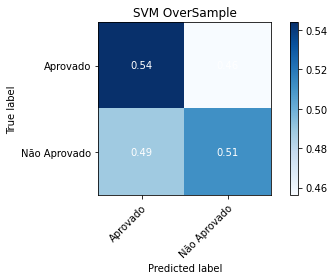


----ROC Curve----
AUC: 0.49
0.488984088127295 
-----------------



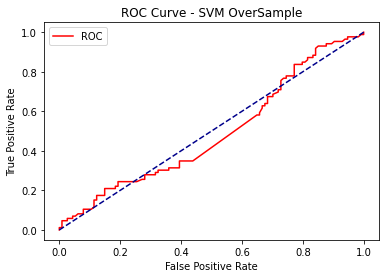

In [30]:
sampling = RandomOverSampler()
clf = svm.SVC(kernel='linear', probability=True)
result, results_folds, bestModel = cross_validation_stratified(X, y, clf, 'SVM OverSample', columns, sampling)

In [31]:
result

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
SVM OverSample,0.475,0.407332,0.460829,0.432432,0.449035,200.0,275.0,0.236677


In [32]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.480,0.423423,0.540230,0.474747,0.511983,47.0,49.0,0.486929
Fold2,0.460,0.391753,0.436782,0.413043,0.426966,38.0,54.0,0.457329
Fold3,0.420,0.340659,0.356322,0.348315,0.353075,31.0,53.0,0.412674
Fold4,0.485,0.416667,0.459770,0.437158,0.450450,40.0,57.0,0.482097
Fold5,0.530,0.458333,0.511628,0.483516,0.500000,44.0,62.0,0.527744


In [33]:
search(X, y)

C:\Users\vinic\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [  nan 0.503 0.489 0.486 0.481 0.483 0.479]
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__penalty,param_estimator__max_depth,param_estimator__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.008777,2.129473e-03,0.001795,0.000399,DecisionTreeClassifier(max_depth=10),NaN,10,NaN,{'estimator': DecisionTreeClassifier(max_depth...,0.520,0.565,0.405,0.505,0.520,0.503,0.052972,1
2,0.013165,1.933040e-03,0.001795,0.000399,DecisionTreeClassifier(max_depth=10),NaN,20,NaN,{'estimator': DecisionTreeClassifier(max_depth...,0.520,0.470,0.470,0.490,0.495,0.489,0.018547,2
3,0.013165,1.322780e-03,0.001795,0.000746,DecisionTreeClassifier(max_depth=10),NaN,None,NaN,{'estimator': DecisionTreeClassifier(max_depth...,0.545,0.485,0.440,0.460,0.500,0.486,0.035972,3
5,0.829832,4.491889e-02,0.043785,0.003195,RandomForestClassifier(),NaN,NaN,250,"{'estimator': RandomForestClassifier(), 'estim...",0.550,0.450,0.460,0.440,0.515,0.483,0.042379,4
4,0.314780,1.455622e-02,0.017752,0.001596,RandomForestClassifier(),NaN,NaN,100,"{'estimator': RandomForestClassifier(), 'estim...",0.555,0.445,0.430,0.460,0.515,0.481,0.046840,5
6,2.418011,4.048596e-02,0.111057,0.005534,RandomForestClassifier(),NaN,NaN,1000,"{'estimator': RandomForestClassifier(), 'estim...",0.550,0.425,0.420,0.475,0.525,0.479,0.052096,6
0,0.000998,6.468134e-07,0.000000,0.000000,LogisticRegression(),l1,NaN,NaN,"{'estimator': LogisticRegression(), 'estimator...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7


### Situação 2 - Classificação: Dados socioeconômicos + primeiro módulo

In [34]:
X = pd.concat([df_sociais, df_modulo1], axis=1)
columns = X.columns
X = preprocess(X, cols_ord, cats_ord, cols_nom, cols_num)

best fold 1
best fold 2
best fold 4
best fold 5


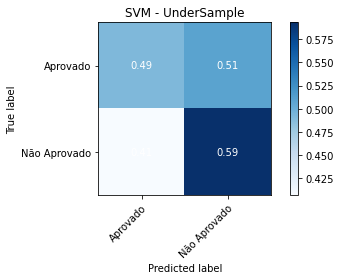


----ROC Curve----
AUC: 0.49
0.49127906976744184 
-----------------



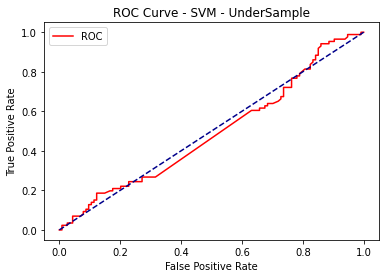

In [47]:
sampling = RandomUnderSampler()
clf = svm.SVC(kernel='linear', probability=True)
result, results_folds, bestModel = cross_validation_stratified(X, y, clf, 'SVM - UnderSample', columns, sampling)

In [48]:
result

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
SVM - UnderSample,0.497,0.434034,0.523041,0.474399,0.502435,227.0,270.0,0.250052


In [49]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.495,0.432692,0.517241,0.471204,0.497788,45.0,54.0,0.497559
Fold2,0.505,0.440000,0.505747,0.470588,0.491071,44.0,57.0,0.505086
Fold3,0.430,0.357895,0.390805,0.373626,0.383747,34.0,52.0,0.425491
Fold4,0.520,0.460870,0.609195,0.524752,0.572354,53.0,51.0,0.530261
Fold5,0.535,0.467890,0.593023,0.523077,0.562914,51.0,56.0,0.542126


In [50]:
search(X, y)

C:\Users\vinic\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [  nan 0.504 0.488 0.492 0.481 0.483 0.485]
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__penalty,param_estimator__max_depth,param_estimator__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.008776,0.000747,0.001995,0.000630,DecisionTreeClassifier(max_depth=10),NaN,10,NaN,{'estimator': DecisionTreeClassifier(max_depth...,0.520,0.565,0.400,0.510,0.525,0.504,0.055263,1
3,0.014162,0.001934,0.001596,0.000798,DecisionTreeClassifier(max_depth=10),NaN,None,NaN,{'estimator': DecisionTreeClassifier(max_depth...,0.535,0.480,0.465,0.470,0.510,0.492,0.026571,2
2,0.012766,0.000746,0.001596,0.000488,DecisionTreeClassifier(max_depth=10),NaN,20,NaN,{'estimator': DecisionTreeClassifier(max_depth...,0.515,0.475,0.450,0.485,0.515,0.488,0.024819,3
6,2.733668,0.101943,0.103787,0.004266,RandomForestClassifier(),NaN,NaN,1000,"{'estimator': RandomForestClassifier(), 'estim...",0.555,0.440,0.445,0.480,0.505,0.485,0.042308,4
5,1.028293,0.132786,0.040712,0.001933,RandomForestClassifier(),NaN,NaN,250,"{'estimator': RandomForestClassifier(), 'estim...",0.550,0.455,0.420,0.475,0.515,0.483,0.045453,5
4,0.304186,0.016119,0.017753,0.001716,RandomForestClassifier(),NaN,NaN,100,"{'estimator': RandomForestClassifier(), 'estim...",0.535,0.450,0.425,0.465,0.530,0.481,0.043977,6
0,0.000598,0.000488,0.000000,0.000000,LogisticRegression(),l1,NaN,NaN,"{'estimator': LogisticRegression(), 'estimator...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7


### Situação 3 - Classificação: Todos os dados

In [151]:
X = pd.concat([df_sociais, df_modulo1, df_modulo2], axis=1)
columns = X.columns
X = preprocess(X, cols_ord, cats_ord, cols_nom, cols_num)

best fold 1
best fold 2
best fold 4


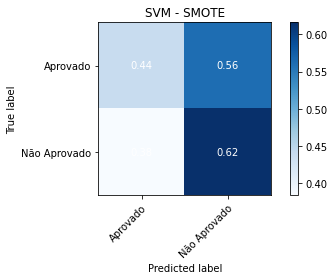


----ROC Curve----
AUC: 0.50
0.5 
-----------------



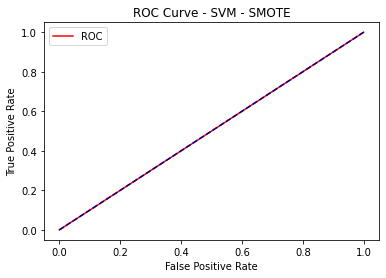

In [146]:
sampling = SMOTE()
clf = svm.SVC(kernel='linear', probability=True)
result, results_folds, bestModel = cross_validation_stratified(X, y, clf, 'SVM - SMOTE', columns, sampling)

In [147]:
result

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
SVM - SMOTE,0.487,0.427523,0.536866,0.475996,0.510741,233.0,254.0,0.246458


In [148]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.465,0.395833,0.436782,0.415301,0.427928,38.0,55.0,0.461754
Fold2,0.505,0.441176,0.517241,0.476190,0.500000,45.0,56.0,0.506408
Fold3,0.430,0.371429,0.448276,0.406250,0.430464,39.0,47.0,0.432103
Fold4,0.520,0.464000,0.666667,0.547170,0.613108,58.0,46.0,0.536873
Fold5,0.515,0.452991,0.616279,0.522167,0.574837,53.0,50.0,0.527438


In [149]:
search(X, y)

C:\Users\vinic\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [  nan 0.498 0.49  0.483 0.49  0.485 0.486]
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__penalty,param_estimator__max_depth,param_estimator__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.008775,7.469266e-04,0.001596,0.000489,DecisionTreeClassifier(max_depth=10),NaN,10,NaN,{'estimator': DecisionTreeClassifier(max_depth...,0.505,0.560,0.400,0.510,0.515,0.498,0.052783,1
2,0.012964,1.670093e-03,0.001596,0.000489,DecisionTreeClassifier(max_depth=10),NaN,20,NaN,{'estimator': DecisionTreeClassifier(max_depth...,0.525,0.475,0.455,0.490,0.505,0.490,0.024083,2
4,0.280558,7.938278e-03,0.016955,0.001093,RandomForestClassifier(),NaN,NaN,100,"{'estimator': RandomForestClassifier(), 'estim...",0.570,0.465,0.430,0.465,0.520,0.490,0.049295,2
6,2.196601,5.352763e-02,0.104332,0.006169,RandomForestClassifier(),NaN,NaN,1000,"{'estimator': RandomForestClassifier(), 'estim...",0.550,0.455,0.435,0.465,0.525,0.486,0.043863,4
5,0.761816,5.099718e-02,0.033982,0.002444,RandomForestClassifier(),NaN,NaN,250,"{'estimator': RandomForestClassifier(), 'estim...",0.565,0.455,0.430,0.445,0.530,0.485,0.052820,5
3,0.013364,2.325751e-03,0.001596,0.000489,DecisionTreeClassifier(max_depth=10),NaN,None,NaN,{'estimator': DecisionTreeClassifier(max_depth...,0.510,0.465,0.465,0.460,0.515,0.483,0.024207,6
0,0.000997,2.611745e-07,0.000000,0.000000,LogisticRegression(),l1,NaN,NaN,"{'estimator': LogisticRegression(), 'estimator...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
